In [1]:
import torch
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification
from torch.utils.data import Dataset
import os
import pandas as pd
import requests
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef
import re
import warnings

warnings.filterwarnings("ignore")

D:\python\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
model_name = './prot_bert'

In [3]:
class DeepLocDataset(Dataset):
    def __init__(self, split="train", tokenizer_name='Rostlab/prot_bert', max_length=1024):
        self.datasetFolderPath = 'dataset3/'
        self.trainFilePath = os.path.join(self.datasetFolderPath, 'train.csv')
        self.testFilePath = os.path.join(self.datasetFolderPath, 'test.csv')
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, do_lower_case=False)
        if split=="train":
            self.seqs, self.labels = self.load_dataset(self.trainFilePath)
        else:
            self.seqs, self.labels = self.load_dataset(self.testFilePath)
        self.max_length = max_length
        
    def load_dataset(self,path):
        df = pd.read_csv(path,names=['input','labels'],skiprows=1)
        seq = list(df['input'])
        seq = [' '.join(i) for i in seq]
        label = list(df['labels'])
        assert len(seq) == len(label)
        return seq, label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        seq = " ".join("".join(self.seqs[idx].split()))
        seq = re.sub(r"[UZOB]", "X", seq)
        seq_ids = self.tokenizer(seq, truncation=True, padding='max_length', max_length=self.max_length)
        sample = {key: torch.tensor(val) for key, val in seq_ids.items()}
        sample['labels'] = torch.tensor(self.labels[idx])
        return sample

In [4]:
train_dataset = DeepLocDataset(split="train", tokenizer_name=model_name, max_length=80)
test_dataset = DeepLocDataset(split="test", tokenizer_name=model_name, max_length=80)

In [5]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mcc' : matthews_corrcoef(labels, preds)
    }

In [6]:
def model_init():
      return AutoModelForSequenceClassification.from_pretrained(model_name)

In [7]:
training_args = TrainingArguments(
    learning_rate=2e-5,
    output_dir='./results',
    num_train_epochs=40,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=2,
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    gradient_accumulation_steps=64,
    fp16=True,
    fp16_opt_level="02",
    run_name="ProBert-BFD-MS",
    seed=42
)

# 10

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics = compute_metrics,
)

trainer.train()

Some weights of the model checkpoint at ./prot_bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized fr

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc,Runtime,Samples Per Second
0,0.694000,0.691793,0.525346,0.000000,0.000000,0.000000,0.000000,2.273800,190.873000
1,0.942800,0.691097,0.525346,0.000000,0.000000,0.000000,0.000000,2.265600,191.560000
2,0.940200,0.688716,0.578341,0.207792,0.960000,0.116505,0.240297,2.266400,191.493000
3,0.934400,0.678282,0.781106,0.767726,0.773399,0.762136,0.560829,2.338000,185.628000
4,0.915900,0.659519,0.790323,0.793651,0.744681,0.849515,0.587628,2.208400,196.525000
5,0.880600,0.635541,0.785714,0.791011,0.736402,0.854369,0.580300,2.275600,190.720000
6,0.834300,0.611768,0.778802,0.779817,0.739130,0.825243,0.562372,2.251200,192.790000
7,0.787900,0.588069,0.781106,0.782609,0.740260,0.830097,0.567392,2.278600,190.471000
8,0.730600,0.580590,0.762673,0.771619,0.710204,0.844660,0.537061,2.257400,192.256000
9,0.692700,0.529255,0.822581,0.815348,0.805687,0.825243,0.644835,2.362800,183.681000


TrainOutput(global_step=80, training_loss=0.5112057216465473, metrics={'train_runtime': 1218.2089, 'train_samples_per_second': 0.066, 'total_flos': 13889239734967680, 'epoch': 39.74})

In [8]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.49533843994140625,
 'eval_accuracy': 0.815668202764977,
 'eval_f1': 0.8148148148148148,
 'eval_precision': 0.7787610619469026,
 'eval_recall': 0.8543689320388349,
 'eval_mcc': 0.6348004320670899,
 'eval_runtime': 2.2293,
 'eval_samples_per_second': 194.682,
 'epoch': 39.74}

In [9]:
# trainer.save_model('./model/bert939.pt')

In [10]:
result = trainer.predict(test_dataset).predictions
golden = trainer.predict(test_dataset).label_ids
result = torch.argmax(torch.tensor(result), -1)

<AxesSubplot:>

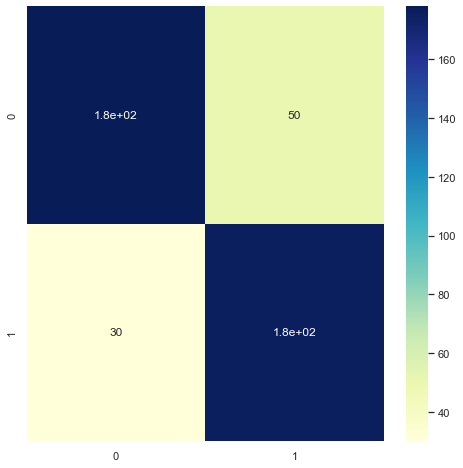

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(8,8))
C2= confusion_matrix(list(golden), list(result))
sns.heatmap(C2,annot=True, cmap="YlGnBu")